In [109]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,5)
pd.set_option('display.max_columns', 100)

import nltk
from scipy import stats
import re
from  scipy.stats import ttest_ind
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
data=pd.read_csv('Data/cleanedData.csv')
data.dropna(subset=['CleanWordList'],inplace=True)
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,%OfNoOfStopWords,NoOfWords,%OfNoOfUniqueWords,AvgSentenceLength,TextStandard,CleanWordList
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,1.79,0,6.12,32.14,13,1.000,8.0,3.0,huh anyway check tube channel kobyoshi99
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,12.05,0,4.22,26.51,40,0.775,15.0,6.0,hey guy check new channel first vid u monkey '...


In [88]:
cols=['COMMENT_ID','%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       '%OfNoOfStopWords', 'NoOfWords', '%OfNoOfUniqueWords',
       'AvgSentenceLength', 'TextStandard', 'CleanWordList']

X=data.loc[:,cols]
y=data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25 ,random_state=147)

countVectorizer=CountVectorizer(min_df=5,ngram_range=(1,3))

In [89]:
X_train_dtm = countVectorizer.fit_transform(X_train['CleanWordList']) 
X_test_dtm  = countVectorizer.transform(X_test['CleanWordList'])

In [90]:
X_train.head(2)

,COMMENT_ID,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,%OfNoOfStopWords,NoOfWords,%OfNoOfUniqueWords,AvgSentenceLength,TextStandard,CleanWordList
794,z12ldxsqzsvvwf5h404cjh5ooxincztrles,1.32,0,3.53,40.79,18,1.000000,17.0,6.0,anyone else think video theme bit insult 99 da...
210,z12kyn0qjzzzur2ai04cg5szenjxdrorp4w,4.44,1,10.38,28.89,13,0.923077,8.0,9.0,please friend read book repass


In [91]:
colName=countVectorizer.get_feature_names()

X_train_df=pd.DataFrame(X_train_dtm.toarray(),columns=colName)
X_test_df=pd.DataFrame(X_test_dtm.toarray(),columns=colName)

In [97]:
#Initialize clasifier
clf=MultinomialNB()
clf.fit(X_train_df,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [98]:
predict = clf.predict(X_test_df)

In [99]:
print("Vocab size:",len(countVectorizer.get_feature_names()))

Vocab size: 729


# Most predictive words

## Most predictive words/phrases for Spam comments

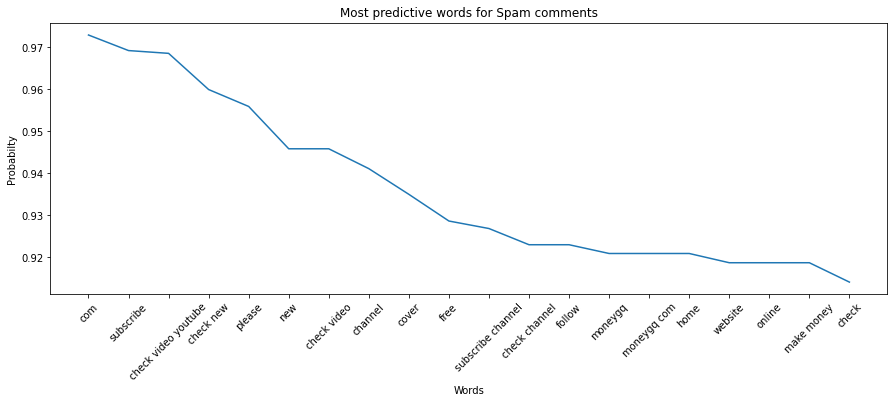

In [143]:
words = np.array(countVectorizer.get_feature_names())
x = np.eye(X_test_df.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

# Top 20 most predictive words for spam and ham 
predictors_of_SPAM = words[ind[:20]]
predictors_of_HAM = words[ind[-20:]]

SPAM_prob = probs[ind[:20]]
HAM_prob = probs[ind[-20:]]

df_spamPredictors=pd.DataFrame(zip(predictors_of_SPAM,(1 - np.exp(SPAM_prob))),
             columns=['Most predictive words for Spam comments','Probabilty'])


sns.lineplot(x='Most predictive words for Spam comments',y='Probabilty',data=df_spamPredictors,sort=False)
plt.title("Most predictive words for Spam comments")
plt.xlabel("Words")
plt.xticks(rotation=45);

### SPAM Comments related to making free money from home

In [162]:
filt=(X_test_df['moneygq']==1) | (X_test_df['moneygq com']==1) | (X_test_df['make money']==1 | (X_test_df['free']==1) | (X_test_df['home']==1))
moneyCommentId=X_test_df[filt].index.tolist()

X_test_temp=X_test.reset_index()
X_test_temp['Prediction']=pd.DataFrame(predict)

# Printing list of comments with Money related words and predicted as SPAM
for id in moneyCommentId:
    commentID=X_test_temp.loc[(X_test_temp.index==id) & (X_test_temp['Prediction']==1),'COMMENT_ID'].iloc[0]
    print(data[data['COMMENT_ID']==commentID].CONTENT.iloc[0])
    print('------------------------------------------------------------------------------------------------------------------')

visit &quot; ww estiloproduction com &quot; best website to make money
------------------------------------------------------------------------------------------------------------------
Hello Guys...I Found a Way to Make Money Online You Can Get Paid To Mess Around On Facebook And Twitter! GET PAID UPTO $25 to $35 AN HOUR...Only at 4NetJobs.com Work from the Comfort of your Home... They are Currently Hiring People from all Over the World, For a Wide Range of Social Media Jobs on Sites such as Facebook,Twitter and YouTube You don&#39;t Need any Prior Skills or Experience and You can Begin Work Immediately! You Can Easily Make $4000 to $5000+ Monthly Income…Only at 4NetJobs.com
------------------------------------------------------------------------------------------------------------------
You guys should check out this EXTRAORDINARY website called ZONEPA.COM .   You can make money online and start working from home today as I am!   I am making over $3,000+ per month at ZONEPA.COM !   V

## Most predictive words/phrases for Ham comments

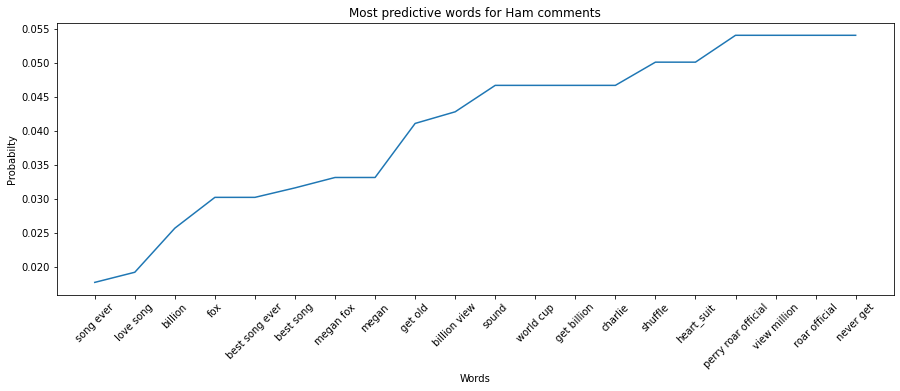

In [113]:
df_hamPredictors=pd.DataFrame(zip(predictors_of_HAM,(1 - np.exp(HAM_prob))),
             columns=['Most predictive words for Ham comments','Probabilty'])

df_hamPredictors.sort_values(by=['Probabilty'], ascending=True, inplace=True)
sns.lineplot(x='Most predictive words for Ham comments',y='Probabilty',data=df_hamPredictors,sort=False)
plt.title("Most predictive words for Ham comments")
plt.xlabel("Words")
plt.xticks(rotation=45);

# Add engineered features and then run machine learning model

In [93]:
# X_train_df=pd.concat([X_train_df.reset_index(drop=True),X_train.reset_index(drop=True)],axis=1,ignore_index=False)

# X_test_df=pd.concat([X_test_df.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1,ignore_index=False)